In [2]:
!pip install -q nltk

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

import itertools
from collections import Counter
from wordcloud import WordCloud
import re

from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.corpus import stopwords 
import operator 

# 导入数据集

In [4]:
data = pd.read_csv('DA job/DataAnalyst.csv', index_col=0)

### 初步思考方向

1. 面临疫情带来的大量失业群体,我们如何利用这个数据集帮助更多需要工作的人。
2. 数据集包含2,000多个数据分析师职位信息,各条记录包含薪资估计、工作地点、公司评分、工作描述等字段，何在这些信息中发掘有价值的洞察来使招聘更加切合实际，且如何精确匹配求职者与工作机会,提高人才招聘的效率与精准度。
3. 薪资估计字段可以用来分析数据分析师薪资水平与趋势, 比较不同城市，公司，岗位要求等的薪资差异
4. 利用工作描述字段中的关键词，分析当前热门的数据分析师技能。
5. 不同关键词对应的薪资中位数也可作为技能与薪资的参照。
5. 公司评分这一信息的分析，可以作为选择公司的一个重要参考因素。
6. 对求职者而言，充分利用这些招聘信息，可以对自己的技能查漏补缺，对行业的发展有全局观，更高效的找到工作

# EDA 数据集初步探索

In [5]:
data.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2253 entries, 0 to 2252
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          2253 non-null   object 
 1   Salary Estimate    2253 non-null   object 
 2   Job Description    2253 non-null   object 
 3   Rating             2253 non-null   float64
 4   Company Name       2252 non-null   object 
 5   Location           2253 non-null   object 
 6   Headquarters       2253 non-null   object 
 7   Size               2253 non-null   object 
 8   Founded            2253 non-null   int64  
 9   Type of ownership  2253 non-null   object 
 10  Industry           2253 non-null   object 
 11  Sector             2253 non-null   object 
 12  Revenue            2253 non-null   object 
 13  Competitors        2253 non-null   object 
 14  Easy Apply         2253 non-null   object 
dtypes: float64(1), int64(1), object(13)
memory usage: 281.6+ KB


### 通过观察表格数据，发现最后两列Competitors和Easy Apply均存在缺失值，关键词为-1

In [7]:
# 将不同type的列缺失值标注出来
data.replace(-1, np.nan, inplace=True)
data.replace('-1', np.nan, inplace=True)
data.isna().sum()

Job Title               0
Salary Estimate         1
Job Description         0
Rating                272
Company Name            1
Location                0
Headquarters          172
Size                  163
Founded               660
Type of ownership     163
Industry              353
Sector                353
Revenue               163
Competitors          1732
Easy Apply           2173
dtype: int64

先将缺失严重的列删除

In [8]:
# 删除缺失值大于50%的列
null_pct = data.isnull().sum() / len(data)

cols_to_drop = null_pct[null_pct > 0.5].index.tolist()

data.drop(cols_to_drop, axis=1, inplace=True)
data.isna().sum()

Job Title              0
Salary Estimate        1
Job Description        0
Rating               272
Company Name           1
Location               0
Headquarters         172
Size                 163
Founded              660
Type of ownership    163
Industry             353
Sector               353
Revenue              163
dtype: int64

In [9]:
data.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961.0,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD)
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893.0,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD)
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003.0,Company - Private,Internet,Information Technology,Unknown / Non-Applicable
3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002.0,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD)
4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009.0,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD)


### 将剩下的有用列信息进行详细解读

In [10]:
data.shape

(2253, 13)

In [11]:
data.iloc[0, :]

Job Title            Data Analyst, Center on Immigration and Justic...
Salary Estimate                             $37K-$66K (Glassdoor est.)
Job Description      Are you eager to roll up your sleeves and harn...
Rating                                                             3.2
Company Name                            Vera Institute of Justice\n3.2
Location                                                  New York, NY
Headquarters                                              New York, NY
Size                                              201 to 500 employees
Founded                                                         1961.0
Type of ownership                               Nonprofit Organization
Industry                                             Social Assistance
Sector                                                      Non-Profit
Revenue                                     $100 to $500 million (USD)
Name: 0, dtype: object

### 对数值型列特征进行了解

In [12]:
data.select_dtypes(include=[np.number]).describe()

,Rating,Founded
count,1981.000000,1593.000000
mean,3.731903,1978.362837
std,0.670332,47.822289
min,1.000000,1682.000000
25%,3.300000,1970.000000
50%,3.700000,1997.000000
75%,4.100000,2006.000000
max,5.000000,2019.000000


只有两列数值型特征，分别是对公司的评级和建立年份，暂时无价值

### 对非数值型特征列进行了解

In [13]:
data.select_dtypes(include='object').describe().T

,count,unique,top,freq
Job Title,2253,1272,Data Analyst,405
Salary Estimate,2252,89,$42K-$76K (Glassdoor est.),57
Job Description,2253,2253,Are you eager to roll up your sleeves and harn...,1
Company Name,2252,1513,"Staffigo Technical Services, LLC\n5.0",58
Location,2253,253,"New York, NY",310
Headquarters,2081,482,"New York, NY",206
Size,2090,8,51 to 200 employees,421
Type of ownership,2090,14,Company - Private,1273
Industry,1900,88,IT Services,325
Sector,1900,24,Information Technology,570


### 初步结论：
1. 最高薪资范围：42𝐾−76K
2. 招聘岗位最多的公司为Staffigo Technical Services，出现了58次
3. 大部分岗位都位于 New York, NY
4. 公司大小划分有8个量级，大部分为51-200人
5. 招聘最多的行业和部门都是IT

#### 出现新的缺失值关键词 Unknown

In [14]:
cat_cols = data.select_dtypes(include='object')

for col in cat_cols:
    print(col + " = " + str((data[col].str.contains("Unknown")).sum()))

Job Title = 0
Salary Estimate = 0
Job Description = 0
Company Name = 0
Location = 0
Headquarters = 0
Size = 42
Type of ownership = 16
Industry = 0
Sector = 0
Revenue = 615


汇总空值

In [15]:
unknowns = ["Revenue", "Size", "Type of ownership"]
for col in unknowns:
    data.loc[data[col].str.contains("Unknown", na=False), col] = np.nan
    
data.isna().sum()

Job Title              0
Salary Estimate        1
Job Description        0
Rating               272
Company Name           1
Location               0
Headquarters         172
Size                 205
Founded              660
Type of ownership    179
Industry             353
Sector               353
Revenue              778
dtype: int64

## 初步清理数据结束

## 对评分Rating相关进行分析

In [16]:
# 对公司进行去重
data_unique = data.drop_duplicates(subset='Company Name', keep="first")

print(f"Droped: {len(data_unique) - len(data_unique)};\nLeaved: {len(data_unique)}")

Droped: 0;
Leaved: 1514


In [17]:
# 每个公司在每个部门平均发布了多少个工作机会
off_per_comp = (data['Sector'].value_counts() / data_unique['Sector'].value_counts()).sort_values(ascending=False).round(1)
off_per_comp

Sector
Accounting & Legal                    2.2
Restaurants, Bars & Food Services     2.0
Business Services                     1.8
Information Technology                1.7
Insurance                             1.6
Telecommunications                    1.6
Education                             1.5
Finance                               1.5
Government                            1.4
Health Care                           1.4
Real Estate                           1.3
Media                                 1.3
Retail                                1.3
Aerospace & Defense                   1.3
Consumer Services                     1.3
Transportation & Logistics            1.2
Biotech & Pharmaceuticals             1.2
Construction, Repair & Maintenance    1.1
Oil, Gas, Energy & Utilities          1.1
Non-Profit                            1.1
Manufacturing                         1.1
Arts, Entertainment & Recreation      1.0
Mining & Metals                       1.0
Travel & Tourism           

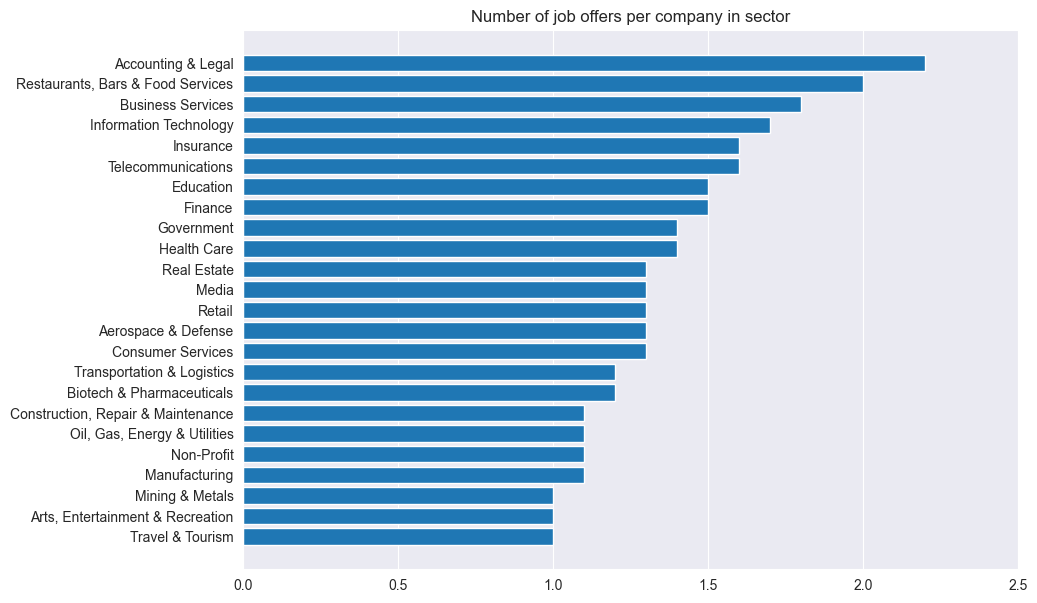

In [18]:
# 可视化
off_per_comp.sort_values(inplace=True)

plt.figure(figsize=(10,7))

plt.barh(off_per_comp.index, off_per_comp)
plt.grid(axis='y')
plt.title("Number of job offers per company in sector")
plt.xlim(0, 2.5)

plt.show()

In [19]:
off_per_comp.describe()

count    24.000000
mean      1.375000
std       0.316571
min       1.000000
25%       1.100000
50%       1.300000
75%       1.525000
max       2.200000
Name: count, dtype: float64

### 结论
大部分发布一个岗位  
Accounting & Legal  
Restaurants, Bars & Food Services  
这两类公司平均发布2个

In [20]:
# 不同Sector的评分
data_grouped = data_unique[['Sector', 'Rating']].groupby("Sector").agg(rating_avg=('Rating', 'mean'), 
                                                                   rating_std=('Rating', 'std'), 
                                                                   count=("Rating", 'size'))
data_grouped.head(10)

,rating_avg,rating_std,count
Sector,,,
Accounting & Legal,3.575000,0.510804,20
Aerospace & Defense,3.647059,0.425907,17
"Arts, Entertainment & Recreation",3.800000,0.877496,7
Biotech & Pharmaceuticals,3.396296,0.622947,27
Business Services,3.813333,0.645759,292
"Construction, Repair & Maintenance",3.590000,0.260128,14
Consumer Services,3.509091,0.732741,11
Education,3.973529,0.538971,35
Finance,3.576106,0.567619,114


In [21]:
# 观察count数据分布
data_grouped['count'].value_counts().sort_values(ascending=False).sort_index()

count
1      2
4      1
7      2
9      1
11     1
12     1
14     1
16     1
17     1
20     1
24     1
26     1
27     1
29     1
31     1
32     1
35     1
38     1
110    1
114    1
292    1
343    1
Name: count, dtype: int64

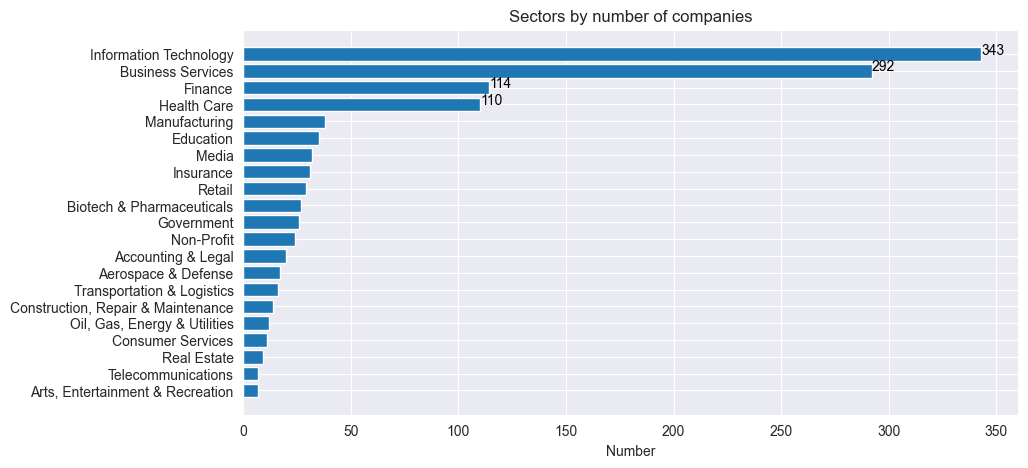

In [22]:
# 按公司数量划分的行业
data_grouped = data_grouped[data_grouped['count'] >= 7]

data_grouped = data_grouped.sort_values(by='count', ascending=True)

plt.figure(figsize=(10,5))

plt.barh(data_grouped.index, data_grouped['count'])

for i, v in enumerate(data_grouped['count'].tail(4)):
    plt.text(v+0.2, len(data_grouped)-4+i, str(v), color='black', fontweight='medium')
    
plt.title("Sectors by number of companies")
plt.xlabel("Number")

plt.show()

### IT 和商业公司的数量远远超过其它部门，处于第一梯队

### 金融和健康类型的部门处于第二梯队

## 对工资进行分析

In [23]:
# 对工资列数据进行初步观察
data['Salary Estimate'].value_counts().sort_values(ascending=False)

Salary Estimate
$42K-$76K (Glassdoor est.)    57
$41K-$78K (Glassdoor est.)    57
$50K-$86K (Glassdoor est.)    41
$35K-$67K (Glassdoor est.)    33
$43K-$76K (Glassdoor est.)    31
                              ..
$42K-$63K (Glassdoor est.)     4
$47K-$81K (Glassdoor est.)     3
$43K-$77K (Glassdoor est.)     3
$36K-$67K (Glassdoor est.)     3
$57K-$70K (Glassdoor est.)     2
Name: count, Length: 89, dtype: int64

### 转换格式，便于分析

In [24]:
# 先备份
data2 = data.copy()

data2['Salary Estimate'].isna().any()

True

In [25]:
data2[data2['Salary Estimate'].isna()]

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue
2149,Configuration/Data Management Analyst III,NaN,Job Description\nPosition Title: Configuration...,4.4,Protingent\n4.4,"Kent, WA","Bellevue, WA",51 to 200 employees,2001.0,Company - Private,Staffing & Outsourcing,Business Services,$25 to $50 million (USD)


In [26]:
# 丢失缺失值
data2.dropna(subset=['Salary Estimate'], inplace=True)

In [27]:
# 将工资的min和max都提取成新列
data2['Salary Estimate'] = data2['Salary Estimate'].str.replace('$', '').str.replace('K', '').str.replace('(Glassdoor est.)', '')
data2[['Min Salary','Max Salary']] = data2['Salary Estimate'].str.split('-', expand=True).astype(int)*1000

In [28]:
data2.drop('Salary Estimate', axis=1).head()

,Job Title,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Min Salary,Max Salary
0,"Data Analyst, Center on Immigration and Justic...",Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961.0,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),37000,66000
1,Quality Data Analyst,Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893.0,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),37000,66000
2,"Senior Data Analyst, Insights & Analytics Team...",We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003.0,Company - Private,Internet,Information Technology,NaN,37000,66000
3,Data Analyst,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002.0,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),37000,66000
4,Reporting Data Analyst,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009.0,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),37000,66000


### 探索工资在不同城市的情况

In [29]:
data2['Location'].value_counts()

Location
New York, NY         310
Chicago, IL          130
San Francisco, CA    119
Austin, TX            81
Los Angeles, CA       80
                    ... 
Carrollton, TX         1
Tarrant, TX            1
Addison, TX            1
Burr Ridge, IL         1
Littleton, CO          1
Name: count, Length: 253, dtype: int64

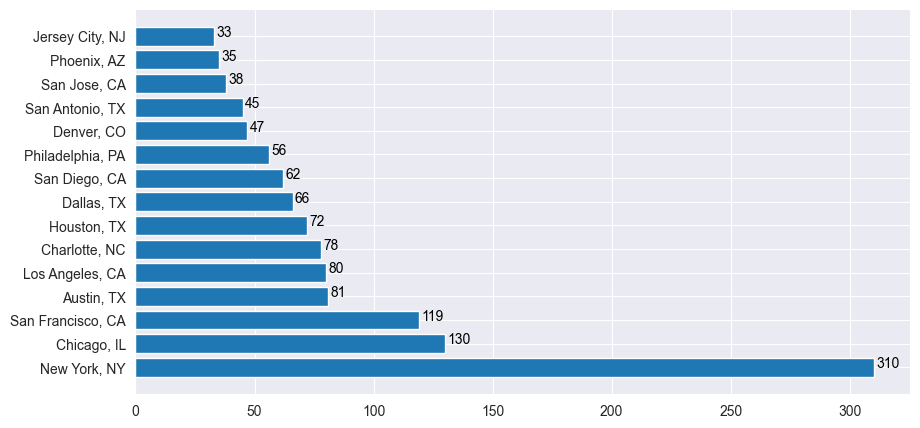

In [30]:
# 根据公司Location，选取重复最多的前15，进行详细分析
df = data2['Location'].value_counts()

plt.figure(figsize=(10,5))

plt.barh(df.index[:15], df[:15])

for i, v in enumerate(df[:15]):
    plt.text(v+1, i, str(v), color='black', fontweight='medium')

plt.show()

### 可以看出，New York一骑绝尘，遥遥领先；第二梯队，Chicago, IL 和San Francisco不相上下，但加起来都没有NY多。  
### 由此可得，数据分析师的工作在大城市有更多的机会。

### 我们接着探索薪资情况，猜测拥有更多机会的大城市，薪资水平也会更高

用公司数量排行最多的15个地方进行工资的mean和std计算

In [31]:
top_15 = data2['Location'].value_counts().nlargest(15).index.tolist()
top_cities = data2[data2['Location'].isin(top_15)]

city_sal = top_cities.groupby('Location').agg(count=('Location', 'size'),
                                             mean_low = ('Min Salary', 'mean'),
                                             std_low = ('Min Salary', 'std'),
                                             mean_high = ('Max Salary', 'mean'),
                                             std_high = ('Max Salary', 'std'))
city_sal.sort_values(by=['mean_high'], ascending=False)

,count,mean_low,std_low,mean_high,std_high
Location,,,,,
"San Jose, CA",38,79421.052632,20751.595939,138289.473684,34489.252454
"San Francisco, CA",119,72521.008403,20265.127741,126025.210084,34988.245529
"San Diego, CA",62,64870.967742,12025.224678,118048.387097,17061.535129
"Phoenix, AZ",35,48342.857143,3984.845241,96971.428571,5164.845617
"Chicago, IL",130,68507.692308,16833.542628,88946.153846,20866.616467
"New York, NY",310,53574.193548,17460.801550,88896.774194,20281.729050
"Jersey City, NJ",33,53333.333333,18423.264278,88000.000000,21330.729008
"Denver, CO",47,57468.085106,8682.443715,86085.106383,15152.600275
"Charlotte, NC",78,51179.487179,3674.211956,85166.666667,9516.106192


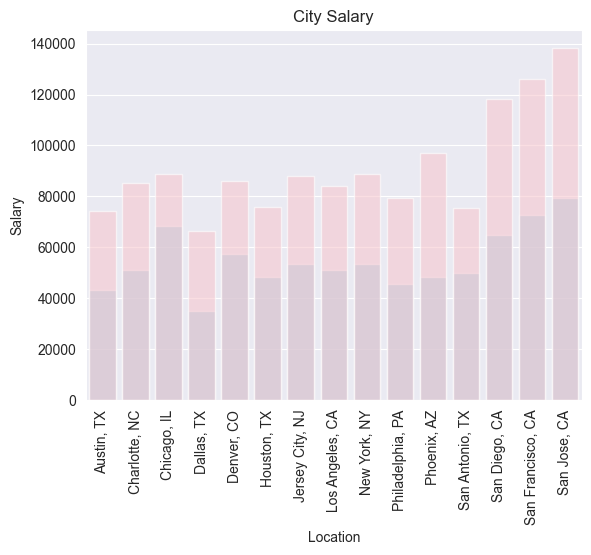

In [32]:
# 进行可视化观察

# 绘制平均工资条形图
sns.barplot(x=city_sal.index, y='mean_low', data=city_sal, color='skyblue', alpha=0.6)
sns.barplot(x=city_sal.index, y='mean_high', data=city_sal, color='pink', alpha=0.6)

# 设置图表标题和坐标轴标签
plt.title('City Salary')
plt.xlabel('Location')
plt.ylabel('Salary')

plt.xticks(rotation=90)

plt.show()

In [36]:
city_sal.sort_values(by='count', ascending=False, inplace=True)

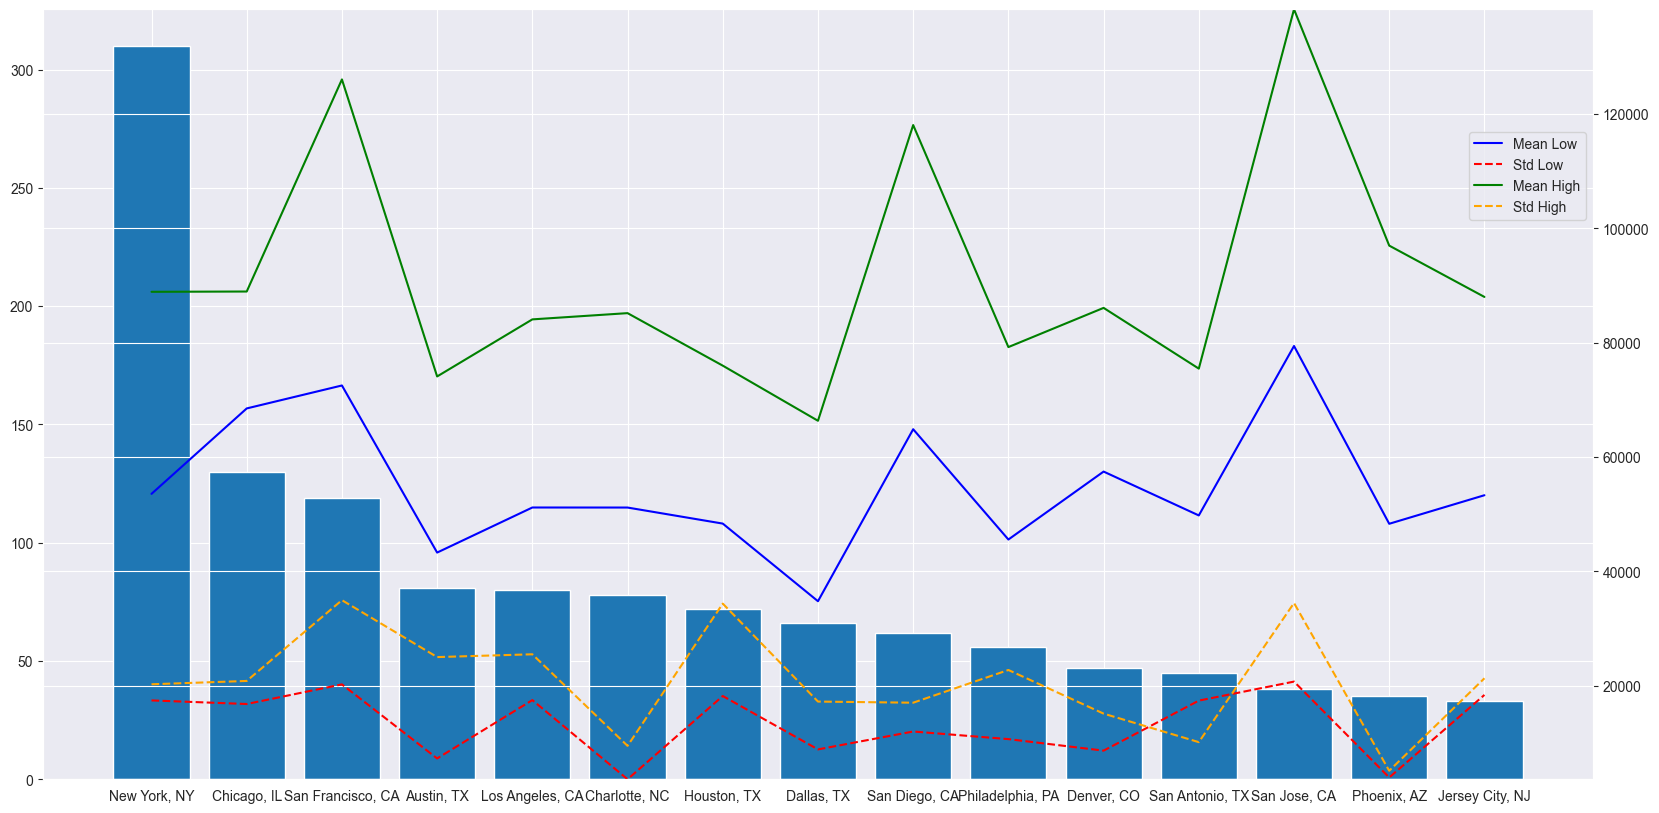

In [37]:
# 获取四条折线的最大与最小值,用于设置Y轴范围
max_values = []
min_values = []
for df in [city_sal['mean_low'], city_sal['std_low'], city_sal['mean_high'], city_sal['std_high']]:
    max_values.append(df.max())
    min_values.append(df.min())
max_value = max(max_values)
min_value = min(min_values)



# 创建条形图并添加y轴标签
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(city_sal.index, city_sal['count'])
# 添加第一个折线,设置y轴范围
ax2 = ax.twinx()
ax2.plot(city_sal.index, city_sal['mean_low'], color='blue', label='Mean Low')
ax2.set_ylim(min_value, max_value) 
# 添加其他三条折线,共用ax2的y轴
ax3 = ax2       
ax3.plot(city_sal.index, city_sal['std_low'], color='red', label='Std Low',linestyle='--')
ax4 = ax2
ax4.plot(city_sal.index, city_sal['mean_high'], color='green', label='Mean High')
ax5 = ax2 
ax5.plot(city_sal.index, city_sal['std_high'], color='orange', label='Std High',linestyle='--')

# label放置
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax3.legend(loc='upper right', bbox_to_anchor=(1, 0.95))
ax4.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax5.legend(loc='upper right', bbox_to_anchor=(1, 0.85))


plt.show()

从图表中看出，拥有岗位数量越多的城市，不一定平均工资是最高的，但标准差较小，数据相对稳定

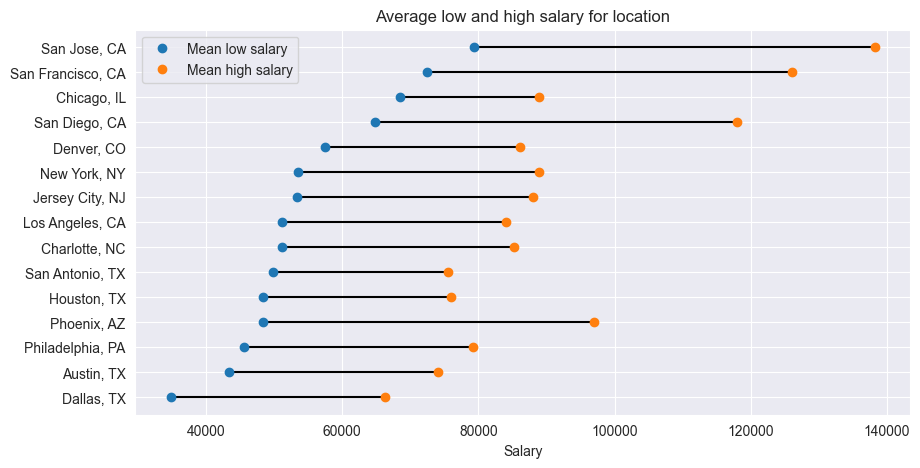

In [38]:
# 进一步观察平均工资在不同城市的特征
city_sal.sort_values(by="mean_low", inplace=True)

plt.figure(figsize=(10,5))

plt.hlines(city_sal.index, xmin=city_sal['mean_low'], xmax=city_sal['mean_high'], colors='black')
plot1, = plt.plot(city_sal['mean_low'], city_sal.index, "o", label="low")
plot2, = plt.plot(city_sal['mean_high'], city_sal.index, "o", label="high")

plt.legend([plot1,plot2],["Mean low salary", "Mean high salary"])

plt.title("Average low and high salary for location")
plt.xlabel("Salary")

plt.show()

可以看出最低薪资均值在不同城市中，变化较为稳定，但是最高薪资均值则极为不同

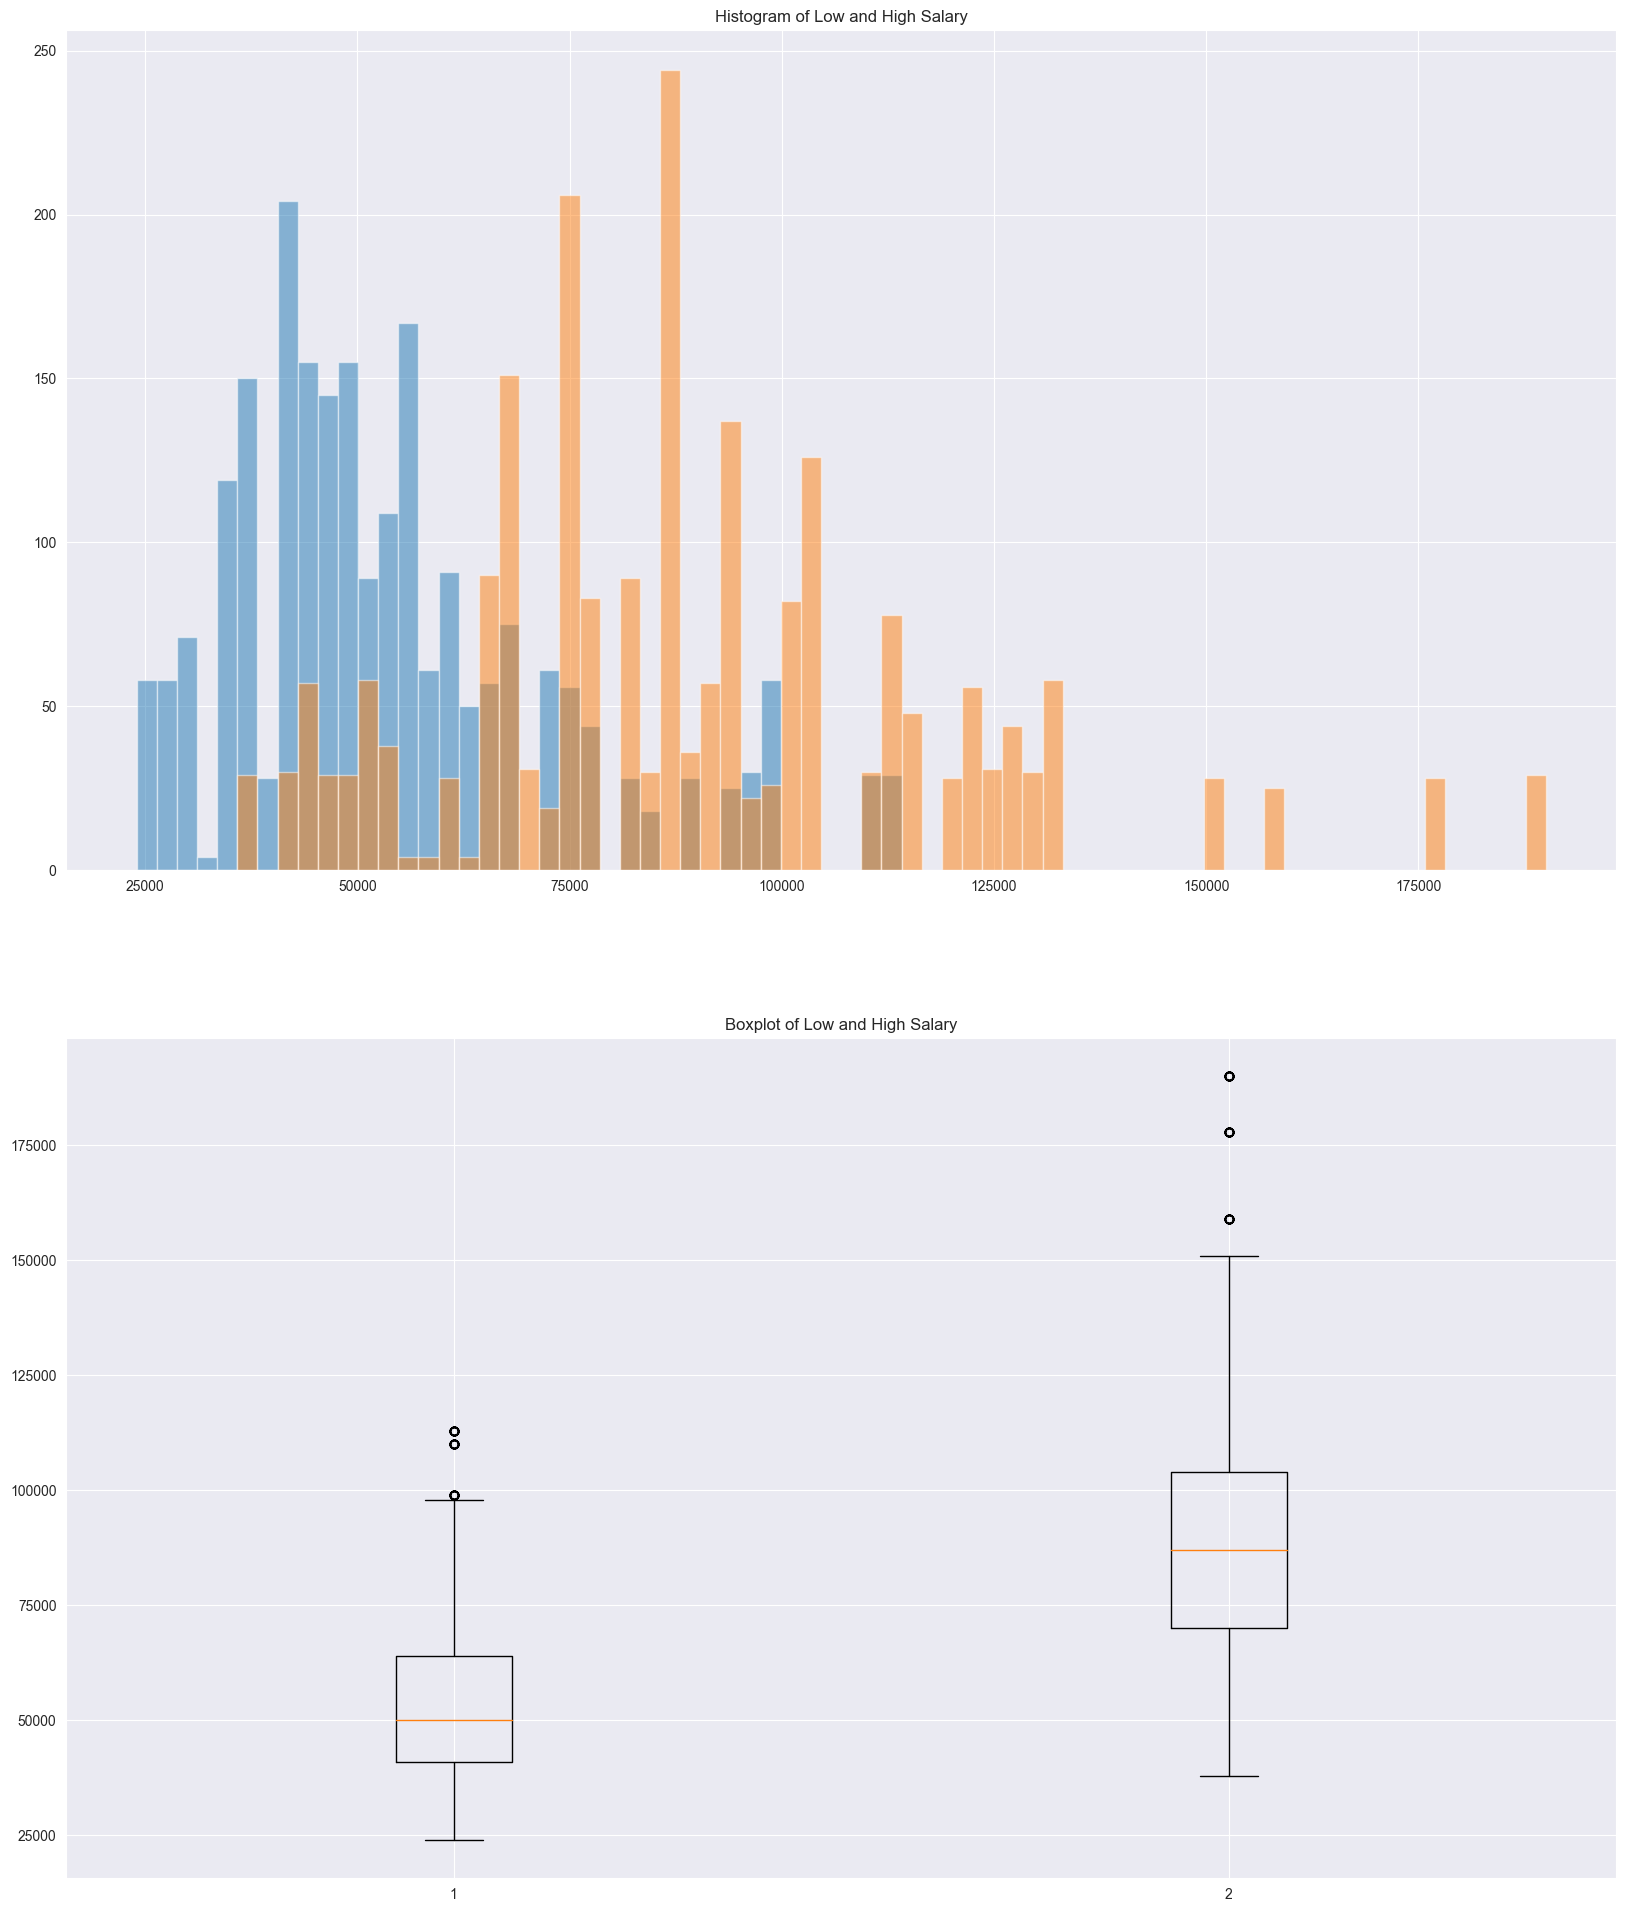

In [39]:
# 绘制薪资直方图和箱型图上下排列
plt.figure(figsize=(20,24))

# 设置两个子图
ax1 = plt.subplot(2,1,1)  
ax2 = plt.subplot(2,1,2)

# 绘制直方图  
n = data2['Min Salary'].shape[0]
bins = np.linspace(data2['Min Salary'].min(), data2['Max Salary'].max(), int(1.5*np.sqrt(n))) 
ax1.hist(data2['Min Salary'], bins=bins, alpha=0.5)  
ax1.hist(data2['Max Salary'], bins=bins, alpha=0.5)  

# 绘制箱型图
ax2.boxplot([data2['Min Salary'], data2['Max Salary']])   

# 设置子图的标题 
ax1.set_title('Histogram of Low and High Salary')
ax2.set_title('Boxplot of Low and High Salary')

plt.show()

检验得出最低薪资较为符合正态分布且比较集中；但是最高薪资不太符合，上下限范围大，且存在更多的异常值

### 继续深挖薪资特征下的岗位特征，比如从Job title里提取关键词，预测工作经验也会对薪资有大影响

In [40]:
data2.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Min Salary,Max Salary
0,"Data Analyst, Center on Immigration and Justic...",37-66,Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961.0,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),37000,66000
1,Quality Data Analyst,37-66,Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893.0,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),37000,66000
2,"Senior Data Analyst, Insights & Analytics Team...",37-66,We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003.0,Company - Private,Internet,Information Technology,NaN,37000,66000
3,Data Analyst,37-66,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002.0,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),37000,66000
4,Reporting Data Analyst,37-66,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009.0,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),37000,66000


In [41]:
data3 = data2.copy()

data3 = data3.drop(['Salary Estimate'], axis=1)

In [42]:
data3['Job Title'].value_counts().head(20)

Job Title
Data Analyst               405
Senior Data Analyst         90
Junior Data Analyst         30
Business Data Analyst       28
Sr. Data Analyst            21
Data Quality Analyst        17
Data Analyst Junior         17
Data Analyst II             17
Data Governance Analyst     16
Lead Data Analyst           15
Data Reporting Analyst      13
Financial Data Analyst      12
Data Analyst I              11
Data Analyst III            11
Sr Data Analyst              9
Marketing Data Analyst       9
Data Management Analyst      8
Data Warehouse Analyst       8
SQL Data Analyst             7
Technical Data Analyst       7
Name: count, dtype: int64

In [43]:
# 下载词云相关
!pip install -q wordcloud

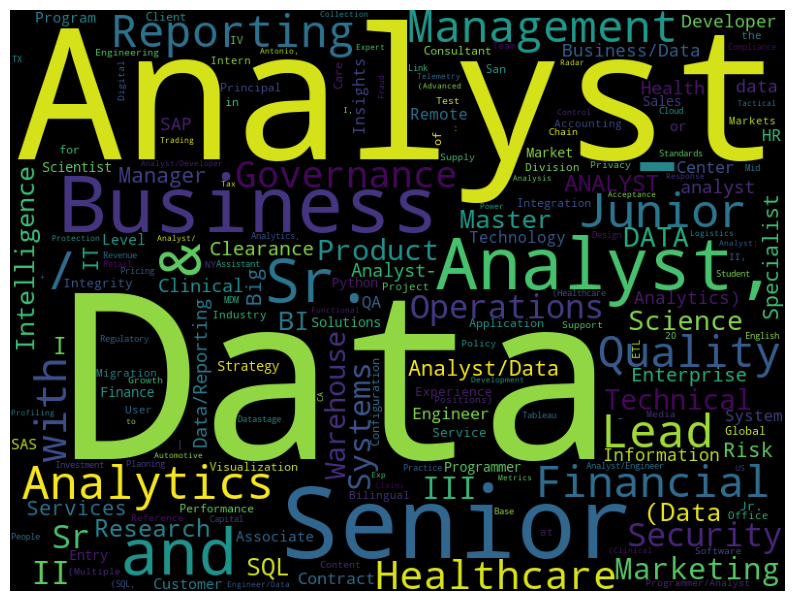

The most common words: 
[('Data', 2162), ('Analyst', 1970), ('-', 320), ('Senior', 276), ('Business', 162), ('Analyst,', 134), ('and', 106), ('Sr.', 90), ('&', 79), ('/', 70)]


In [44]:
# 筛选单词频次
words = data3['Job Title'].str.split()

# 利用itertools.chain()将words中各个词语列表链接起来,得到一个总词语列表all_words
all_words = list(itertools.chain(*words))

# 使用Counter从all_words中统计各个词语的频数
word_counts = Counter(all_words)

# 绘制词云图
wordcloud = WordCloud(width=800, height=600).generate_from_frequencies(word_counts)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# 显示高频词
print('The most common words: ')
print(word_counts.most_common(10))

通过初步观察Job Title列的信息，73%左右的岗位直接注明需要Data Analyst

In [45]:
# 根据观察，筛选job title的分类
print("Data Analyst: ")
print(data3['Job Title'].str.contains("Data Analyst").value_counts())

print("\nJunior|Jr")
print(data3['Job Title'].str.contains("Junior|Jr").value_counts())

print("\nSenior|Sr")
print(data3['Job Title'].str.contains("Senior|Sr").value_counts())

print("\nI|II|III")
print(data3['Job Title'].str.contains("I|II|III").value_counts())

Data Analyst: 
Job Title
True     1639
False     613
Name: count, dtype: int64

Junior|Jr
Job Title
False    2180
True       72
Name: count, dtype: int64

Senior|Sr
Job Title
False    1841
True      411
Name: count, dtype: int64

I|II|III
Job Title
False    1904
True      348
Name: count, dtype: int64


#### 可以初步筛选Junior|Jr和Senior|Sr，但是对于I|II|III的特征，还待进一步观察，以分类

猜测：
- Data Analyst I: Entry-level/Junior Data Analyst
- Data Analyst II: Mid-level Data Analyst
- Data Analyst III: Senior Data Analyst  
进行验证

In [46]:
job_title1 = data3[data3['Job Title'] == 'Data Analyst I']
job_title1['Job Description'].str.contains("Entry|entry").value_counts()

Job Description
False    7
True     4
Name: count, dtype: int64

In [47]:
job_title1 = data3[data3['Job Title'] == 'Data Analyst I']
job_title1['Job Description'].str.contains("Senior|senior").value_counts()

Job Description
False    11
Name: count, dtype: int64

In [48]:
job_title1 = data3[data3['Job Title'] == 'Data Analyst III']
job_title1['Job Description'].str.contains("Senior|senior").value_counts()

Job Description
False    8
True     3
Name: count, dtype: int64

### 大体确认job title分类标准，进行分组

In [49]:
# 划分工作经验
juniors = data3['Job Title'].str.contains("Junior|Jr|I")

seniors = data3['Job Title'].str.contains("Senior|Sr|II|III")

print('juniors numbers: '+ str(len(data3[juniors])))
print('seniors numbers: '+ str(len(data3[seniors])))

juniors numbers: 420
seniors numbers: 491


In [50]:
# 增添工作经历列
data3['Experience'] = np.nan

data3.loc[juniors, 'Experience'] = 'juniors'
data3.loc[seniors, 'Experience'] = 'seniors'

data3['Experience'].value_counts()

Experience
seniors    491
juniors    294
Name: count, dtype: int64

In [51]:
data3.head()

,Job Title,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Min Salary,Max Salary,Experience
0,"Data Analyst, Center on Immigration and Justic...",Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961.0,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),37000,66000,juniors
1,Quality Data Analyst,Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893.0,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),37000,66000,NaN
2,"Senior Data Analyst, Insights & Analytics Team...",We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003.0,Company - Private,Internet,Information Technology,NaN,37000,66000,seniors
3,Data Analyst,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002.0,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),37000,66000,NaN
4,Reporting Data Analyst,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009.0,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),37000,66000,NaN


### 分类之后，与薪资列 特征进行查看比较

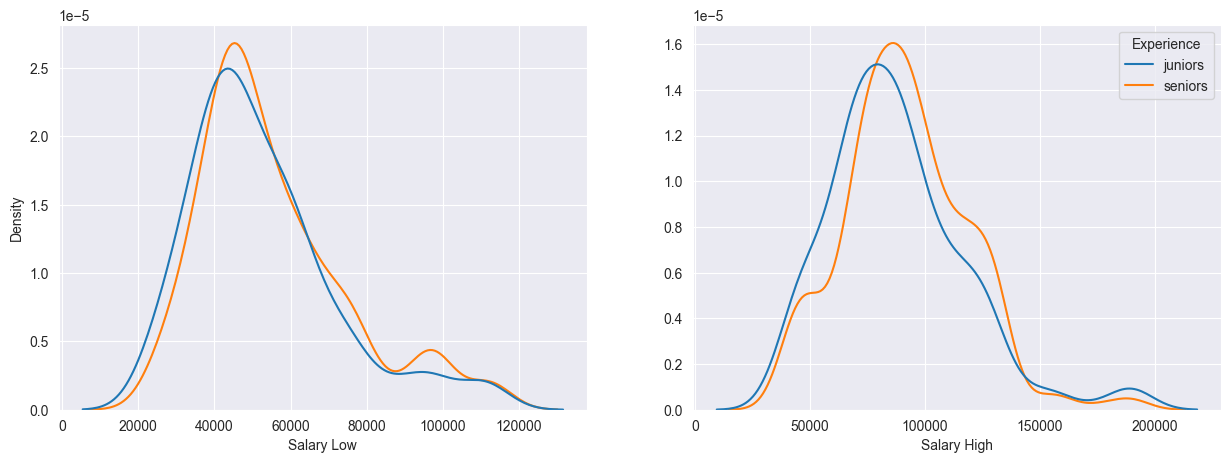

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.kdeplot(ax=axes[0], data=data3, x=data3['Min Salary'], hue="Experience", common_norm=False, legend=False)
axes[0].set_xlabel("Salary Low")

sns.kdeplot(ax=axes[1], data=data3, x=data3['Max Salary'], hue="Experience", common_norm=False)
axes[1].set_xlabel("Salary High")

axes[1].set_ylabel(None)
plt.show()

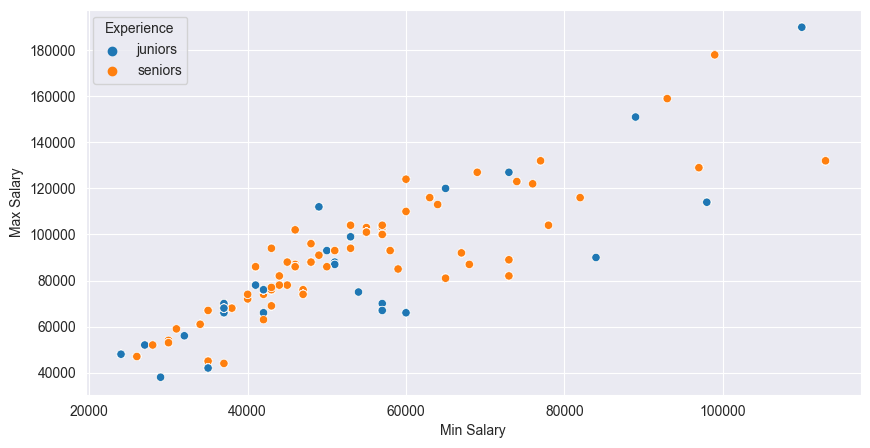

In [53]:
# 继续探索工作经验和薪水的关系
plt.figure(figsize=(10,5))

sns.scatterplot(data=data3, 
                x=data3['Min Salary'], 
                y=data3['Max Salary'], 
                hue="Experience")

plt.show()

### 出乎意料，从图形中可以看出：  
1. 工作经验在薪资上均符合正态分布，但几乎无明显差异
2. 在密度最大的薪资分布上，senior相对有优势
3. 在高薪水时，senior在8W-15W的薪水区间内更有优势，岗位更多

### 进一步提问，如果在同一城市，工作经验会对薪资产生较大影响吗？

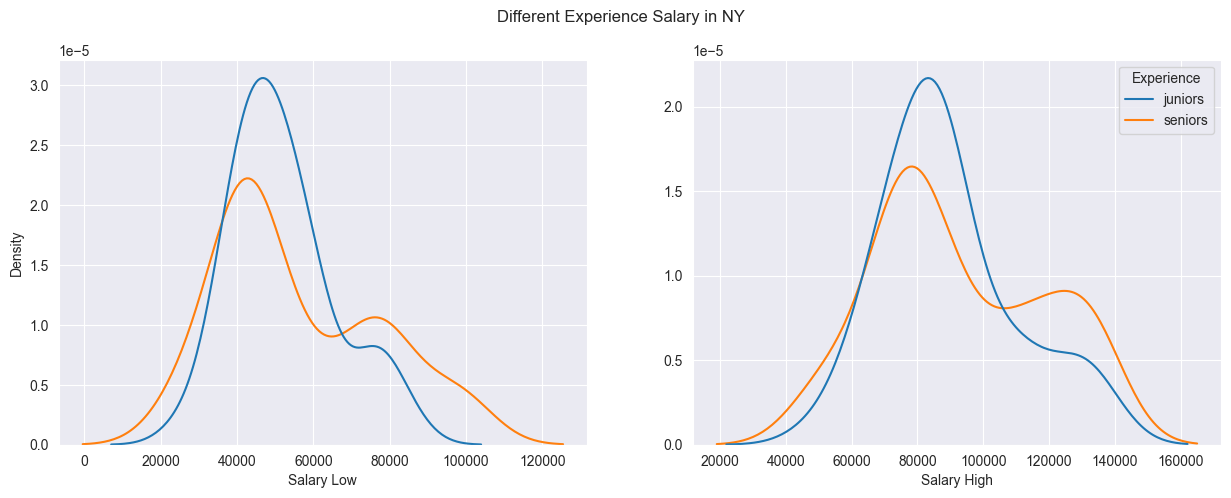

In [84]:
# 设置筛选城市
select_city_sal = data3[data3['Location'] == 'New York, NY']

fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.kdeplot(ax=axes[0], data=select_city_sal, x=select_city_sal['Min Salary'], hue="Experience", common_norm=False, legend=False)
axes[0].set_xlabel("Salary Low")

sns.kdeplot(ax=axes[1], data=data3, x=select_city_sal['Max Salary'], hue="Experience", common_norm=False)
axes[1].set_xlabel("Salary High")

fig.suptitle("Different Experience Salary in NY")
axes[1].set_ylabel(None)

plt.show()

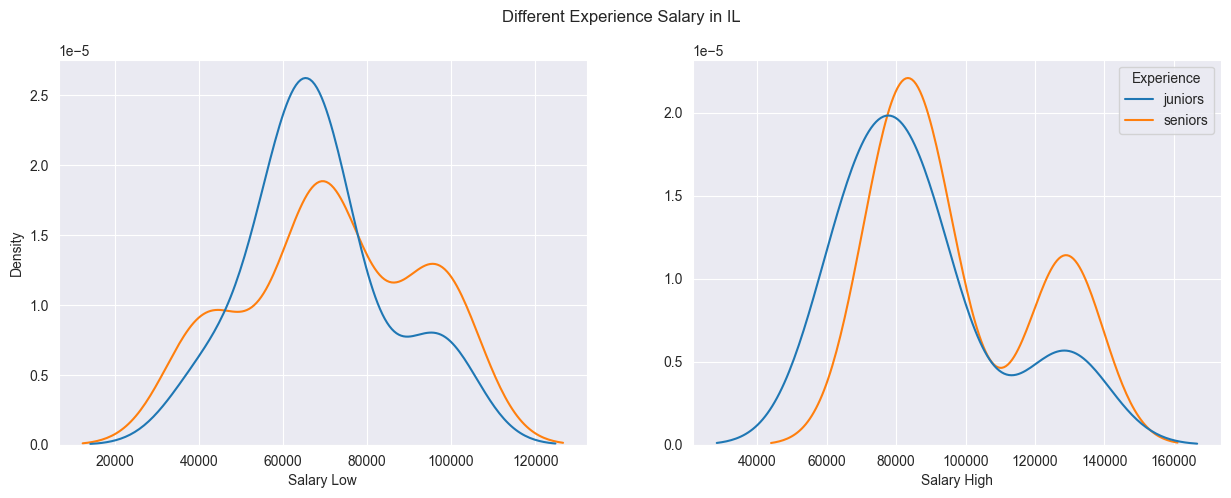

In [86]:
# 设置筛选城市
select_city_sal = data3[data3['Location'] == 'Chicago, IL']

fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.kdeplot(ax=axes[0], data=select_city_sal, x=select_city_sal['Min Salary'], hue="Experience", common_norm=False, legend=False)
axes[0].set_xlabel("Salary Low")

sns.kdeplot(ax=axes[1], data=data3, x=select_city_sal['Max Salary'], hue="Experience", common_norm=False)
axes[1].set_xlabel("Salary High")

fig.suptitle("Different Experience Salary in IL")
axes[1].set_ylabel(None)

plt.show()

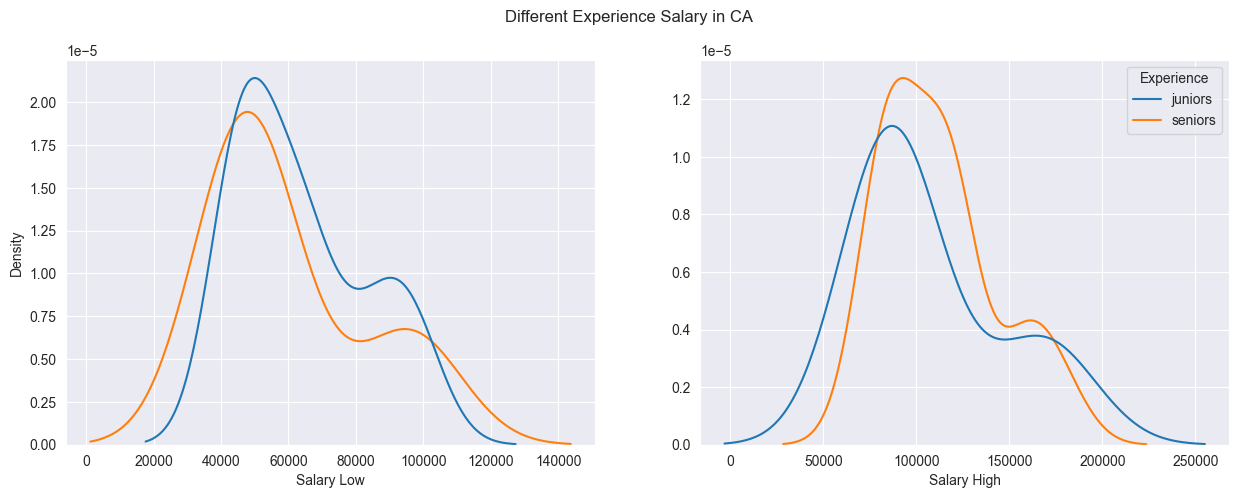

In [87]:
# 设置筛选城市
select_city_sal = data3[data3['Location'] == 'San Francisco, CA']

fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.kdeplot(ax=axes[0], data=select_city_sal, x=select_city_sal['Min Salary'], hue="Experience", common_norm=False, legend=False)
axes[0].set_xlabel("Salary Low")

sns.kdeplot(ax=axes[1], data=data3, x=select_city_sal['Max Salary'], hue="Experience", common_norm=False)
axes[1].set_xlabel("Salary High")

fig.suptitle("Different Experience Salary in CA")
axes[1].set_ylabel(None)

plt.show()

### 通过绘制并观察岗位最多的三个城市，发现在不同的城市表现不一样
### 但在同一城市，工作年限对薪资的影响变得更大，和猜测的结果一致

### 进一步猜测，最高最低薪资的范围太广，导致数据被进一步分散，取区间中位数进行研究

In [90]:
data3['Salary_median'] = round((data3['Min Salary'] + data3['Max Salary'])/2, 0)
data3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2252 entries, 0 to 2252
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          2252 non-null   object 
 1   Job Description    2252 non-null   object 
 2   Rating             1980 non-null   float64
 3   Company Name       2251 non-null   object 
 4   Location           2252 non-null   object 
 5   Headquarters       2080 non-null   object 
 6   Size               2047 non-null   object 
 7   Founded            1592 non-null   float64
 8   Type of ownership  2073 non-null   object 
 9   Industry           1899 non-null   object 
 10  Sector             1899 non-null   object 
 11  Revenue            1474 non-null   object 
 12  Min Salary         2252 non-null   int32  
 13  Max Salary         2252 non-null   int32  
 14  Experience         785 non-null    object 
 15  Salary_median      2252 non-null   float64
dtypes: float64(3), int32(2), obje

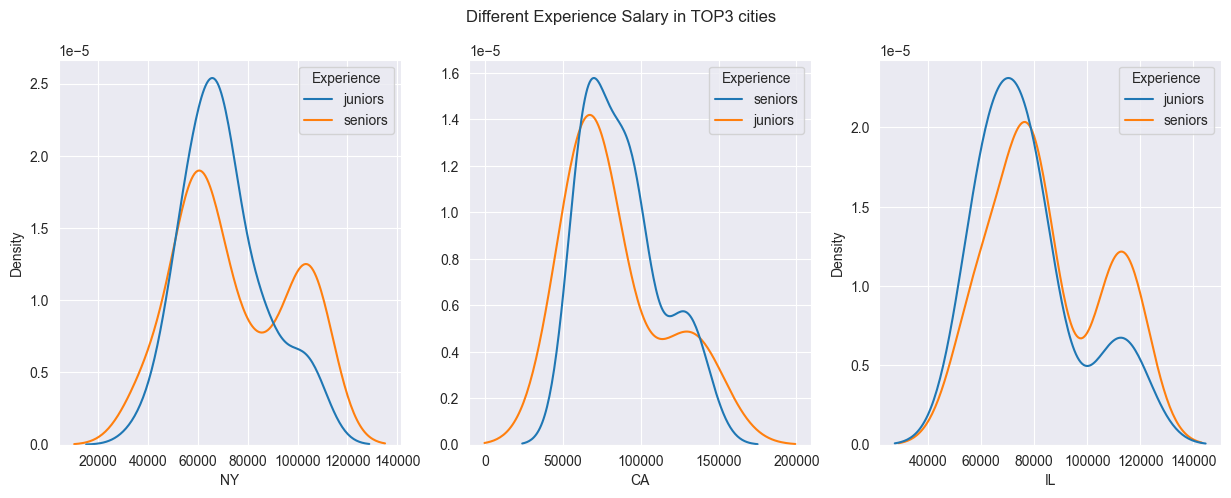

In [109]:
NY_sal = data3[data3['Location'] == 'New York, NY']
CA_sal = data3[data3['Location'] == 'San Francisco, CA']
IL_sal = data3[data3['Location'] == 'Chicago, IL']

fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.kdeplot(ax=axes[0], data=NY_sal, x=NY_sal['Salary_median'], hue="Experience", common_norm=False)
axes[0].set_xlabel("NY")

sns.kdeplot(ax=axes[1], data=CA_sal, x=CA_sal['Salary_median'], hue="Experience", common_norm=False)
axes[1].set_xlabel("CA")

sns.kdeplot(ax=axes[2], data=IL_sal, x=IL_sal['Salary_median'], hue="Experience", common_norm=False)
axes[2].set_xlabel("IL")

fig.suptitle("Different Experience Salary in TOP3 cities")
axes[1].set_ylabel(None)

plt.show()

## 综上所述，城市对薪资的影响较大，且不同城市有所差异
1. 整体而言，在工资较低时，对初级DA的需求更高，薪资越高，高级DA岗位越多
2. 即使在不同城市，初级DA的大部分岗位薪资都在70000左右
3. 初级DA呈单峰正态分布，而高级DA普遍呈现双峰状态，猜测高级DA薪资受影响因素会更多，导致波动大；而初级市场需求差异不大，所有定价一致

# 

# 了解完薪水、城市、工作经验后，探索招聘信息中对应聘者技术的要求

In [54]:
data3.head()

,Job Title,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Min Salary,Max Salary,Experience
0,"Data Analyst, Center on Immigration and Justic...",Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961.0,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),37000,66000,juniors
1,Quality Data Analyst,Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893.0,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),37000,66000,NaN
2,"Senior Data Analyst, Insights & Analytics Team...",We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003.0,Company - Private,Internet,Information Technology,NaN,37000,66000,seniors
3,Data Analyst,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002.0,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),37000,66000,NaN
4,Reporting Data Analyst,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009.0,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),37000,66000,NaN


In [55]:
print(data3['Job Description'][0])
print(str(len(data3['Job Description'][0])) + "words")

Are you eager to roll up your sleeves and harness data to drive policy change? Do you enjoy sifting through complex datasets to illuminate trends and insights? Do you see yourself working for a values-driven organization with a vision to tackle the most pressing injustices of our day?

We are looking to hire a bright, hard-working, and creative individual with strong data management skills and a demonstrated commitment to immigrant's rights. The Data Analyst will assist with analysis and reporting needs for Veras Center on Immigration and Justice (CIJ), working across its current projects and future Vera initiatives.

Who we are:

Founded in 1961, The Vera Institute is an independent, non-partisan, nonprofit organization that combines expertise in research, technical assistance, and demonstration projects to assist leaders in government and civil society examine justice policy and practice, and improve the systems people rely on for justice and safety.
We study problems that impede hum

In [56]:
# 创建岗位描述词库
job_des = data3['Job Description']
words = job_des.str.split()  
all_words = list(itertools.chain(*words))

# 将所有单词都lower
lower_words = [word.lower() for word in all_words]

# 去重，统计词频，并转换为字典，方便遍历
word_counts = dict(Counter(lower_words))


# 设置数据分析关键技能词汇列表
key_skills = ['sql', 'python', 'seaborn', 
              'r', 'sas', 'tableau', 'excel', 
              'spss', 'powerbi', 'hadoop', 
              'azure', 'java', 'spark']

key_skills_counts = {}

# 通过关键词列表遍历简历字典，得到频次
for num in range(0,len(key_skills)):
    skill = key_skills[num]
    
    if skill in word_counts.keys():
        key_skills_counts.update({skill:word_counts[skill]})

key_skills_counts

{'sql': 1547,
 'python': 364,
 'r': 177,
 'sas': 217,
 'tableau': 389,
 'excel': 639,
 'spss': 32,
 'powerbi': 42,
 'hadoop': 77,
 'azure': 68,
 'java': 51,
 'spark': 28}

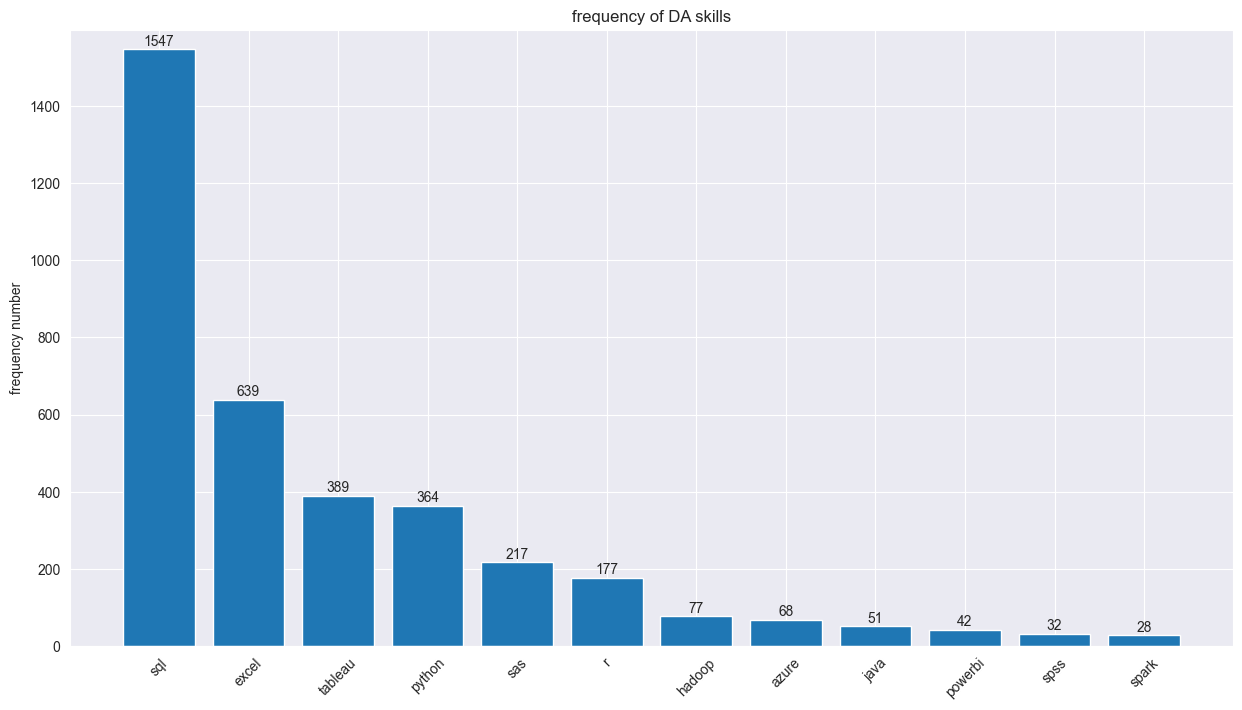

In [57]:
# 对关键技能进行可视化分析

key_skills_counts = {k:v for k, v in sorted(key_skills_counts.items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(15,8))

plt.bar(key_skills_counts.keys(), key_skills_counts.values())

for index, value in enumerate(key_skills_counts.values()):
    plt.text(index, value+10, str(value), ha='center')

plt.xticks(rotation=45)
plt.ylim(0,max(list(key_skills_counts.values()))+50)
plt.title('frequency of DA skills')
plt.ylabel('frequency number')

plt.show()

## 通过对岗位描述提取skills关键词，可以看出，对于数据分析师来说，最最最重要的工具是SQL；其次是excel，紧接着tableau和python. 

### 根据tableau的数据，怀疑powerbi的提取出现了遗漏，进行补充

In [58]:
print(word_counts['power'])
print(word_counts['bi'])

409
454


将power bi的数据填充，重新绘制图表

In [59]:
key_skills_counts['power bi'] = round((word_counts['power'] + word_counts['bi'])/2, 0)

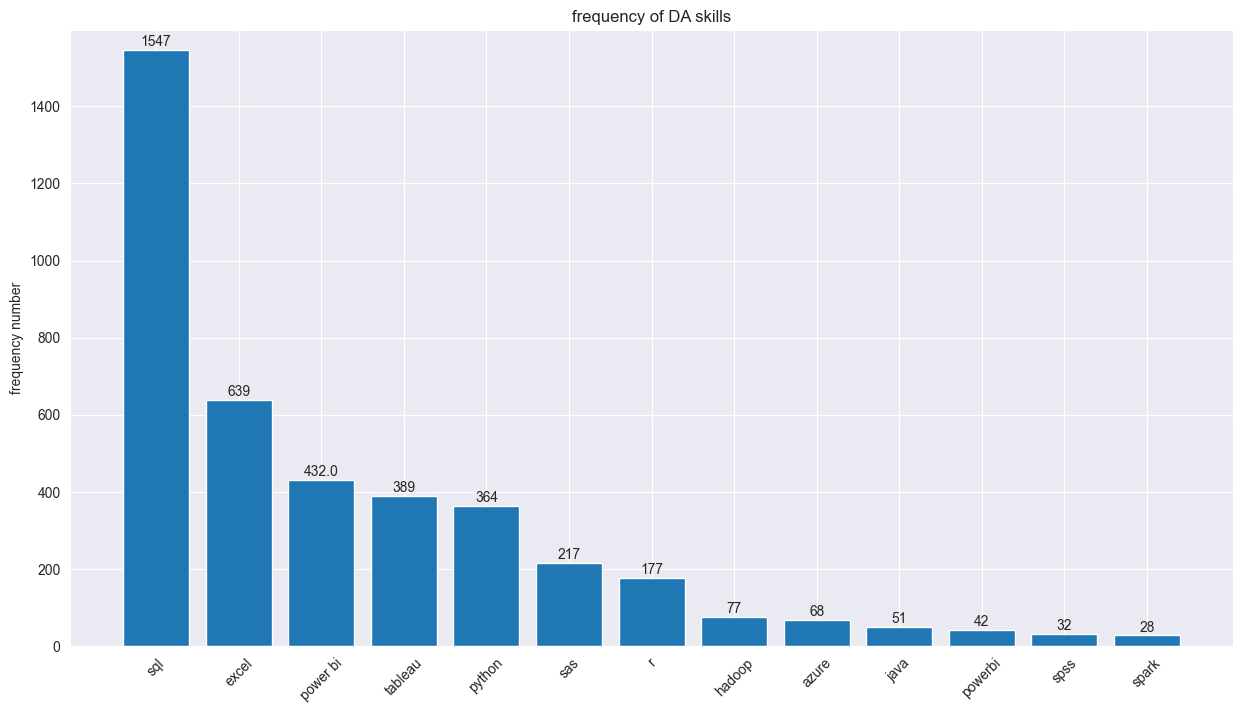

In [60]:
# 对关键技能进行可视化分析

key_skills_counts = {k:v for k, v in sorted(key_skills_counts.items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(15,8))

plt.bar(key_skills_counts.keys(), key_skills_counts.values())

for index, value in enumerate(key_skills_counts.values()):
    plt.text(index, value+10, str(value), ha='center')

plt.xticks(rotation=45)
plt.ylim(0,max(list(key_skills_counts.values()))+50)
plt.title('frequency of DA skills')
plt.ylabel('frequency number')

plt.show()

### 使用Natural Language Toolkit (NLTK)，去除无用词后筛选高频词

In [64]:
word_counts

{'are': 3707,
 'you': 3509,
 'eager': 26,
 'to': 30625,
 'roll': 18,
 'up': 452,
 'your': 1795,
 'sleeves': 14,
 'and': 58835,
 'harness': 8,
 'data': 21662,
 'drive': 756,
 'policy': 240,
 'change?': 1,
 'do': 647,
 'enjoy': 93,
 'sifting': 1,
 'through': 1219,
 'complex': 1333,
 'datasets': 291,
 'illuminate': 1,
 'trends': 438,
 'insights?': 3,
 'see': 141,
 'yourself': 39,
 'working': 2158,
 'for': 10857,
 'a': 14357,
 'values-driven': 7,
 'organization': 524,
 'with': 14563,
 'vision': 264,
 'tackle': 32,
 'the': 24904,
 'most': 468,
 'pressing': 12,
 'injustices': 1,
 'of': 22430,
 'our': 5109,
 'day?': 2,
 'we': 4080,
 'looking': 690,
 'hire': 164,
 'bright,': 8,
 'hard-working,': 4,
 'creative': 182,
 'individual': 387,
 'strong': 2549,
 'management': 2764,
 'skills': 3056,
 'demonstrated': 498,
 'commitment': 149,
 "immigrant's": 1,
 'rights.': 4,
 'analyst': 2940,
 'will': 4423,
 'assist': 697,
 'analysis': 2702,
 'reporting': 2042,
 'needs': 797,
 'veras': 2,
 'center': 255,

In [78]:
stopwords = stopwords.words('english')

def filter_words(words):
    valid_words = []
    for word in words:
        if word.isalpha() and word not in stopwords:
            valid_words.append(word)
    return valid_words


filtered_words = {}
for word, count in word_counts.items(): 
    valid_words = filter_words(word.lower().split())
    for w in valid_words:
        if w in filtered_words:
            filtered_words[w] += count
        else:
            filtered_words[w] = count
            

sorted_words = sorted(filtered_words.items(), key=operator.itemgetter(1), reverse=True) 

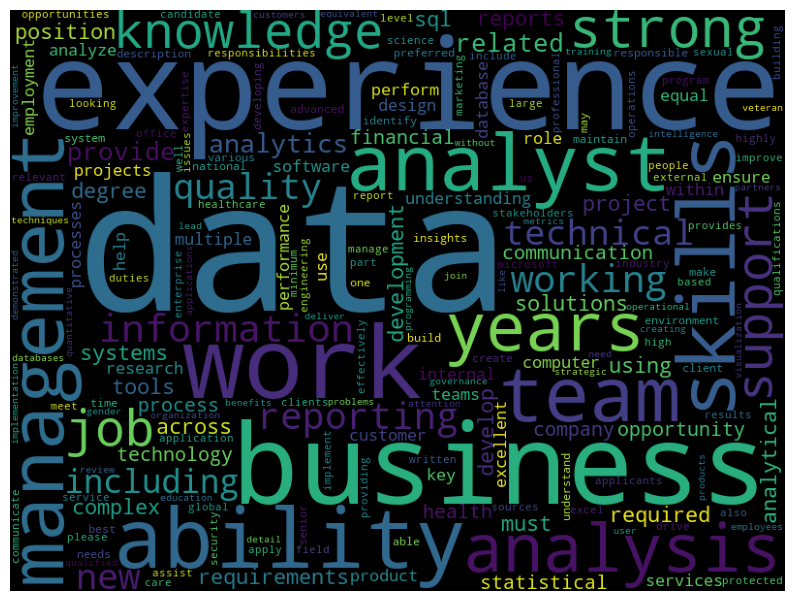

In [79]:
# 绘制词云图
wordcloud = WordCloud(width=800, height=600).generate_from_frequencies(dict(sorted_words))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# 总结

1. 越大的城市就业岗位越多，比如纽约招聘岗位遥遥领先；所有择业优先选择大城市，机会更多
2. 招聘需求中，IT和商业公司岗位最多，金融和健康紧跟其后，择业优势行业，机会更多
3. 初级数据分析师的市场定价较为一致，在$70000左右
4. 高级数据分析师的薪资受影响因素更多，但是大体在11000-13000区间，异常值更多
5. 岗位需求技能，最重要的是SQL，然后是excl，之后是powerbi, tableau和python。